<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Sat Nov 23 20:52:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:01:00.0  On |                  N/A |
| 30%   39C    P3             22W /  160W |    1715MiB /   8188MiB |     34%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.4.0


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path
from torchvision import datasets
from torch.utils.data.dataset import Dataset

# Set up path to data folder
data_path = Path("../../data")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it.
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path}, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    #     request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    #     print("Downloading pizza, steak, sushi data...")
    #     f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

../../data/pizza_steak_sushi directory exists.


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '../../data/pizza_steak_sushi'.
There are 3 directories and 0 images in '../../data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in '../../data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in '../../data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in '../../data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in '../../data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in '../../data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in '../../data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in '../../data/pizza_steak_sushi/train/sushi'.


In [6]:
# Setup train and testing paths
train_path = image_path / "train"
test_path = image_path / "test"

train_path, test_path

(PosixPath('../../data/pizza_steak_sushi/train'),
 PosixPath('../../data/pizza_steak_sushi/test'))

Random image path is: ../../data/pizza_steak_sushi/test/sushi/2276986.jpg
Image class: sushi
Image height: 512
Image width: 512


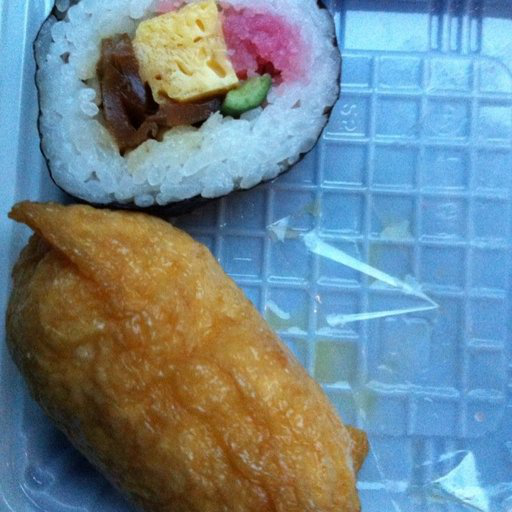

In [7]:
# Visualize an image
import random
from PIL import Image

random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path is: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

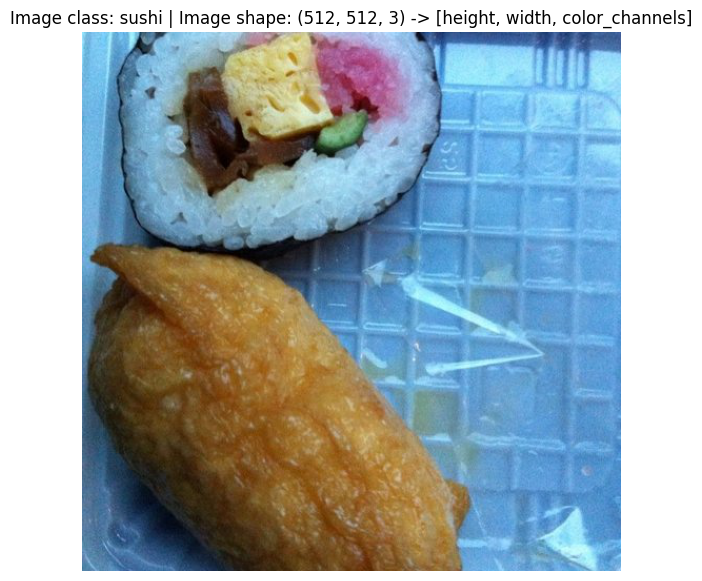

In [8]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [9]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

data_transform_test = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

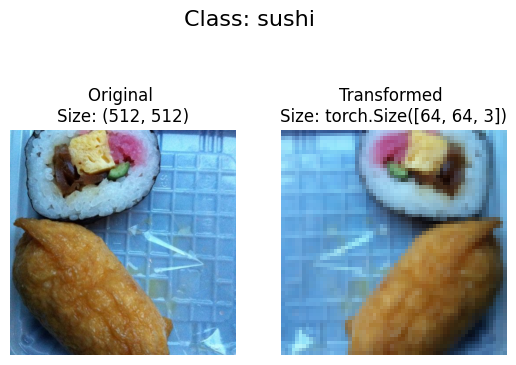

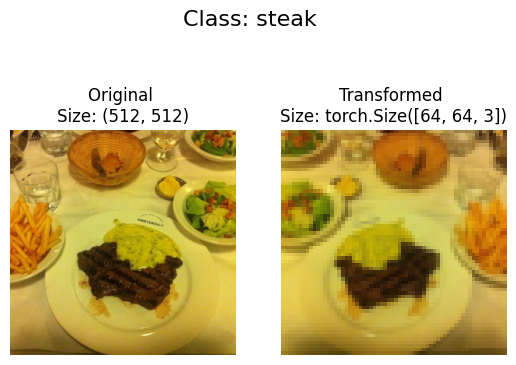

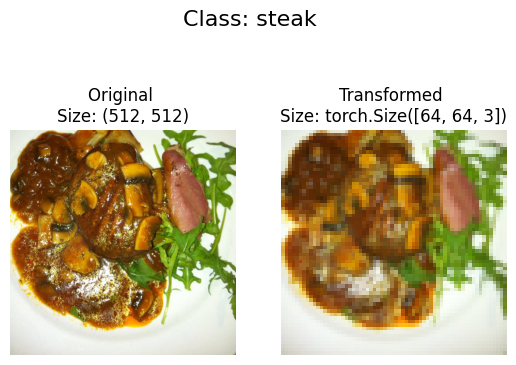

In [11]:
from PIL import Image

# Write a function to plot transformed images
def transformed_image_plotter(image_paths: list,
                              transform,
                              n=3, 
                              seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transformed image and plot
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

transformed_image_plotter(image_path_list, transform=data_transform, n=3)

### Load image data using `ImageFolder`

In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_path,
                                 transform=data_transform_test)

In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [16]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [17]:
# How many batches of images are in our data loaders?
len(train_data), len(test_data)

(225, 75)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [18]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16 * 16,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        return self.classifier(self.block2(self.block1(x)))

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [19]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

torchinfo.summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

## 4. Create training and testing functions for `model_0`.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch_idx, (X, y) in enumerate(train_dataloader):
    # Send data to target device
    X = X.to(device)
    y = y.to(device)

    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
    

    # Calculate and accumualte accuracy metric across all batches
    y_pred_labels = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += ((y_pred_labels == y).sum().item()/len(y_pred_labels))

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch_idx, (X, y) in enumerate(dataloader):
      # Send data to target device
      X = X.to(device)
      y = y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()


      # Calculate and accumulate accuracy
      y_pred_labels = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      test_acc += ((y_pred_labels == y).sum().item()/len(y_pred_labels))
    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

In [45]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [24]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), 
                             lr=0.001)

epoch_5_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=5)

 20%|██        | 1/5 [00:01<00:04,  1.14s/it]

Epoch: 1 | train_loss: 1.0980 | train_acc: 0.3467 | test_loss: 1.0815 | test_acc: 0.4267


 40%|████      | 2/5 [00:02<00:03,  1.03s/it]

Epoch: 2 | train_loss: 1.0529 | train_acc: 0.4844 | test_loss: 1.1021 | test_acc: 0.3733


 60%|██████    | 3/5 [00:03<00:02,  1.03s/it]

Epoch: 3 | train_loss: 0.9770 | train_acc: 0.5600 | test_loss: 1.0069 | test_acc: 0.4667


 80%|████████  | 4/5 [00:04<00:01,  1.05s/it]

Epoch: 4 | train_loss: 0.9103 | train_acc: 0.5778 | test_loss: 1.0277 | test_acc: 0.4000


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]

Epoch: 5 | train_loss: 0.8792 | train_acc: 0.6311 | test_loss: 1.0012 | test_acc: 0.5333


In [25]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0_20 = TinyVGG(3, 10, output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0_20.parameters(), 
                             lr=0.001)

epoch_20_results = train(model=model_0_20,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

  5%|▌         | 1/20 [00:00<00:18,  1.04it/s]

Epoch: 1 | train_loss: 1.1179 | train_acc: 0.2978 | test_loss: 1.0968 | test_acc: 0.4133


 10%|█         | 2/20 [00:02<00:18,  1.01s/it]

Epoch: 2 | train_loss: 1.1003 | train_acc: 0.2889 | test_loss: 1.0995 | test_acc: 0.2533


 15%|█▌        | 3/20 [00:03<00:17,  1.01s/it]

Epoch: 3 | train_loss: 1.0993 | train_acc: 0.3067 | test_loss: 1.0998 | test_acc: 0.3333


 20%|██        | 4/20 [00:04<00:16,  1.00s/it]

Epoch: 4 | train_loss: 1.0991 | train_acc: 0.3244 | test_loss: 1.1001 | test_acc: 0.3333


 25%|██▌       | 5/20 [00:05<00:15,  1.01s/it]

Epoch: 5 | train_loss: 1.0989 | train_acc: 0.3200 | test_loss: 1.1005 | test_acc: 0.3333


 30%|███       | 6/20 [00:06<00:14,  1.01s/it]

Epoch: 6 | train_loss: 1.0990 | train_acc: 0.3467 | test_loss: 1.1009 | test_acc: 0.3333


 35%|███▌      | 7/20 [00:07<00:13,  1.02s/it]

Epoch: 7 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1009 | test_acc: 0.3333


 40%|████      | 8/20 [00:08<00:12,  1.03s/it]

Epoch: 8 | train_loss: 1.0986 | train_acc: 0.3422 | test_loss: 1.1013 | test_acc: 0.3333


 45%|████▌     | 9/20 [00:09<00:11,  1.02s/it]

Epoch: 9 | train_loss: 1.1037 | train_acc: 0.3289 | test_loss: 1.1017 | test_acc: 0.3333


 50%|█████     | 10/20 [00:10<00:10,  1.01s/it]

Epoch: 10 | train_loss: 1.1156 | train_acc: 0.3600 | test_loss: 1.1023 | test_acc: 0.3333


 55%|█████▌    | 11/20 [00:11<00:08,  1.01it/s]

Epoch: 11 | train_loss: 1.1001 | train_acc: 0.3600 | test_loss: 1.1047 | test_acc: 0.2800


 60%|██████    | 12/20 [00:12<00:08,  1.00s/it]

Epoch: 12 | train_loss: 1.0972 | train_acc: 0.3867 | test_loss: 1.1141 | test_acc: 0.3467


 65%|██████▌   | 13/20 [00:13<00:06,  1.00it/s]

Epoch: 13 | train_loss: 1.0479 | train_acc: 0.5156 | test_loss: 1.0651 | test_acc: 0.5067


 70%|███████   | 14/20 [00:14<00:05,  1.00it/s]

Epoch: 14 | train_loss: 0.9708 | train_acc: 0.5778 | test_loss: 1.1508 | test_acc: 0.5200


 75%|███████▌  | 15/20 [00:15<00:04,  1.00it/s]

Epoch: 15 | train_loss: 0.9363 | train_acc: 0.6178 | test_loss: 0.9785 | test_acc: 0.4667


 80%|████████  | 16/20 [00:16<00:04,  1.01s/it]

Epoch: 16 | train_loss: 0.8881 | train_acc: 0.5867 | test_loss: 0.9778 | test_acc: 0.4667


 85%|████████▌ | 17/20 [00:17<00:03,  1.01s/it]

Epoch: 17 | train_loss: 0.8515 | train_acc: 0.6711 | test_loss: 1.0414 | test_acc: 0.4800


 90%|█████████ | 18/20 [00:18<00:02,  1.02s/it]

Epoch: 18 | train_loss: 0.8207 | train_acc: 0.6667 | test_loss: 1.0197 | test_acc: 0.4533


 95%|█████████▌| 19/20 [00:19<00:01,  1.01s/it]

Epoch: 19 | train_loss: 0.8541 | train_acc: 0.6356 | test_loss: 0.9980 | test_acc: 0.5200


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

Epoch: 20 | train_loss: 0.7577 | train_acc: 0.6222 | test_loss: 1.0908 | test_acc: 0.4267


In [26]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0_50 = TinyVGG(3, 10, output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0_50.parameters(), 
                             lr=0.001)

epoch_50_results = train(model=model_0_50,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=50)

  2%|▏         | 1/50 [00:01<00:51,  1.05s/it]

Epoch: 1 | train_loss: 1.1179 | train_acc: 0.2978 | test_loss: 1.0968 | test_acc: 0.4133


  4%|▍         | 2/50 [00:02<00:51,  1.07s/it]

Epoch: 2 | train_loss: 1.1003 | train_acc: 0.2889 | test_loss: 1.0995 | test_acc: 0.2533


  6%|▌         | 3/50 [00:03<00:49,  1.04s/it]

Epoch: 3 | train_loss: 1.0993 | train_acc: 0.3067 | test_loss: 1.0998 | test_acc: 0.3333


  8%|▊         | 4/50 [00:04<00:46,  1.02s/it]

Epoch: 4 | train_loss: 1.0991 | train_acc: 0.3244 | test_loss: 1.1001 | test_acc: 0.3333


 10%|█         | 5/50 [00:05<00:45,  1.01s/it]

Epoch: 5 | train_loss: 1.0989 | train_acc: 0.3200 | test_loss: 1.1005 | test_acc: 0.3333


 12%|█▏        | 6/50 [00:06<00:44,  1.01s/it]

Epoch: 6 | train_loss: 1.0990 | train_acc: 0.3467 | test_loss: 1.1009 | test_acc: 0.3333


 14%|█▍        | 7/50 [00:07<00:44,  1.02s/it]

Epoch: 7 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1009 | test_acc: 0.3333


 16%|█▌        | 8/50 [00:08<00:43,  1.05s/it]

Epoch: 8 | train_loss: 1.0986 | train_acc: 0.3422 | test_loss: 1.1013 | test_acc: 0.3333


 18%|█▊        | 9/50 [00:09<00:43,  1.06s/it]

Epoch: 9 | train_loss: 1.1037 | train_acc: 0.3289 | test_loss: 1.1017 | test_acc: 0.3333


 20%|██        | 10/50 [00:10<00:41,  1.05s/it]

Epoch: 10 | train_loss: 1.1156 | train_acc: 0.3600 | test_loss: 1.1023 | test_acc: 0.3333


 22%|██▏       | 11/50 [00:11<00:40,  1.04s/it]

Epoch: 11 | train_loss: 1.1001 | train_acc: 0.3600 | test_loss: 1.1047 | test_acc: 0.2800


 24%|██▍       | 12/50 [00:12<00:39,  1.03s/it]

Epoch: 12 | train_loss: 1.0972 | train_acc: 0.3867 | test_loss: 1.1141 | test_acc: 0.3467


 26%|██▌       | 13/50 [00:13<00:37,  1.01s/it]

Epoch: 13 | train_loss: 1.0479 | train_acc: 0.5156 | test_loss: 1.0651 | test_acc: 0.5067


 28%|██▊       | 14/50 [00:14<00:36,  1.01s/it]

Epoch: 14 | train_loss: 0.9708 | train_acc: 0.5778 | test_loss: 1.1508 | test_acc: 0.5200


 30%|███       | 15/50 [00:15<00:35,  1.01s/it]

Epoch: 15 | train_loss: 0.9363 | train_acc: 0.6178 | test_loss: 0.9785 | test_acc: 0.4667


 32%|███▏      | 16/50 [00:16<00:34,  1.00s/it]

Epoch: 16 | train_loss: 0.8881 | train_acc: 0.5867 | test_loss: 0.9778 | test_acc: 0.4667


 34%|███▍      | 17/50 [00:17<00:33,  1.01s/it]

Epoch: 17 | train_loss: 0.8515 | train_acc: 0.6711 | test_loss: 1.0414 | test_acc: 0.4800


 36%|███▌      | 18/50 [00:18<00:32,  1.01s/it]

Epoch: 18 | train_loss: 0.8207 | train_acc: 0.6667 | test_loss: 1.0197 | test_acc: 0.4533


 38%|███▊      | 19/50 [00:19<00:30,  1.01it/s]

Epoch: 19 | train_loss: 0.8541 | train_acc: 0.6356 | test_loss: 0.9980 | test_acc: 0.5200


 40%|████      | 20/50 [00:20<00:29,  1.01it/s]

Epoch: 20 | train_loss: 0.7577 | train_acc: 0.6222 | test_loss: 1.0908 | test_acc: 0.4267


 42%|████▏     | 21/50 [00:21<00:28,  1.01it/s]

Epoch: 21 | train_loss: 0.7218 | train_acc: 0.6978 | test_loss: 1.0492 | test_acc: 0.4400


 44%|████▍     | 22/50 [00:22<00:28,  1.00s/it]

Epoch: 22 | train_loss: 0.6959 | train_acc: 0.6889 | test_loss: 1.1080 | test_acc: 0.4400


 46%|████▌     | 23/50 [00:23<00:26,  1.00it/s]

Epoch: 23 | train_loss: 0.6901 | train_acc: 0.7156 | test_loss: 1.0962 | test_acc: 0.5200


 48%|████▊     | 24/50 [00:24<00:25,  1.01it/s]

Epoch: 24 | train_loss: 0.6111 | train_acc: 0.7556 | test_loss: 1.4104 | test_acc: 0.4800


 50%|█████     | 25/50 [00:25<00:24,  1.00it/s]

Epoch: 25 | train_loss: 0.6001 | train_acc: 0.7733 | test_loss: 1.1092 | test_acc: 0.5067


 52%|█████▏    | 26/50 [00:26<00:24,  1.00s/it]

Epoch: 26 | train_loss: 0.6027 | train_acc: 0.7733 | test_loss: 1.1485 | test_acc: 0.4667


 54%|█████▍    | 27/50 [00:27<00:22,  1.01it/s]

Epoch: 27 | train_loss: 0.5345 | train_acc: 0.7867 | test_loss: 1.1360 | test_acc: 0.4933


 56%|█████▌    | 28/50 [00:28<00:22,  1.00s/it]

Epoch: 28 | train_loss: 0.5307 | train_acc: 0.7778 | test_loss: 1.3995 | test_acc: 0.5600


 58%|█████▊    | 29/50 [00:29<00:21,  1.00s/it]

Epoch: 29 | train_loss: 0.5417 | train_acc: 0.7556 | test_loss: 1.0780 | test_acc: 0.5067


 60%|██████    | 30/50 [00:30<00:19,  1.01it/s]

Epoch: 30 | train_loss: 0.5084 | train_acc: 0.8000 | test_loss: 1.1320 | test_acc: 0.5467


 62%|██████▏   | 31/50 [00:31<00:18,  1.03it/s]

Epoch: 31 | train_loss: 0.4412 | train_acc: 0.8444 | test_loss: 1.3517 | test_acc: 0.5200


 64%|██████▍   | 32/50 [00:32<00:17,  1.04it/s]

Epoch: 32 | train_loss: 0.4401 | train_acc: 0.7956 | test_loss: 1.5212 | test_acc: 0.5733


 66%|██████▌   | 33/50 [00:33<00:16,  1.02it/s]

Epoch: 33 | train_loss: 0.4074 | train_acc: 0.8578 | test_loss: 1.3781 | test_acc: 0.5067


 68%|██████▊   | 34/50 [00:34<00:15,  1.02it/s]

Epoch: 34 | train_loss: 0.4105 | train_acc: 0.8178 | test_loss: 1.4944 | test_acc: 0.5333


 70%|███████   | 35/50 [00:35<00:14,  1.02it/s]

Epoch: 35 | train_loss: 0.3363 | train_acc: 0.8667 | test_loss: 1.6399 | test_acc: 0.5600


 72%|███████▏  | 36/50 [00:36<00:13,  1.03it/s]

Epoch: 36 | train_loss: 0.3169 | train_acc: 0.8756 | test_loss: 1.6512 | test_acc: 0.5067


 74%|███████▍  | 37/50 [00:37<00:12,  1.02it/s]

Epoch: 37 | train_loss: 0.3018 | train_acc: 0.8711 | test_loss: 1.7184 | test_acc: 0.4533


 76%|███████▌  | 38/50 [00:38<00:12,  1.00s/it]

Epoch: 38 | train_loss: 0.3107 | train_acc: 0.8578 | test_loss: 1.7540 | test_acc: 0.4800


 78%|███████▊  | 39/50 [00:39<00:10,  1.01it/s]

Epoch: 39 | train_loss: 0.2901 | train_acc: 0.8844 | test_loss: 1.8664 | test_acc: 0.5200


 80%|████████  | 40/50 [00:40<00:09,  1.02it/s]

Epoch: 40 | train_loss: 0.2596 | train_acc: 0.9022 | test_loss: 1.9906 | test_acc: 0.4800


 82%|████████▏ | 41/50 [00:41<00:08,  1.03it/s]

Epoch: 41 | train_loss: 0.2805 | train_acc: 0.8933 | test_loss: 1.9702 | test_acc: 0.4667


 84%|████████▍ | 42/50 [00:42<00:07,  1.02it/s]

Epoch: 42 | train_loss: 0.2683 | train_acc: 0.9067 | test_loss: 2.1295 | test_acc: 0.4667


 86%|████████▌ | 43/50 [00:43<00:06,  1.01it/s]

Epoch: 43 | train_loss: 0.2914 | train_acc: 0.8889 | test_loss: 1.9928 | test_acc: 0.4667


 88%|████████▊ | 44/50 [00:44<00:06,  1.01s/it]

Epoch: 44 | train_loss: 0.1911 | train_acc: 0.9378 | test_loss: 2.3203 | test_acc: 0.4800


 90%|█████████ | 45/50 [00:45<00:05,  1.00s/it]

Epoch: 45 | train_loss: 0.2180 | train_acc: 0.9289 | test_loss: 2.5322 | test_acc: 0.4267


 92%|█████████▏| 46/50 [00:46<00:03,  1.01it/s]

Epoch: 46 | train_loss: 0.2114 | train_acc: 0.9111 | test_loss: 2.5390 | test_acc: 0.4133


 94%|█████████▍| 47/50 [00:47<00:03,  1.00s/it]

Epoch: 47 | train_loss: 0.1781 | train_acc: 0.9244 | test_loss: 2.3213 | test_acc: 0.4933


 96%|█████████▌| 48/50 [00:48<00:02,  1.00s/it]

Epoch: 48 | train_loss: 0.1673 | train_acc: 0.9289 | test_loss: 3.1624 | test_acc: 0.4533


 98%|█████████▊| 49/50 [00:49<00:01,  1.01s/it]

Epoch: 49 | train_loss: 0.1414 | train_acc: 0.9556 | test_loss: 3.1585 | test_acc: 0.4667


100%|██████████| 50/50 [00:50<00:00,  1.00s/it]

Epoch: 50 | train_loss: 0.4090 | train_acc: 0.8711 | test_loss: 2.6013 | test_acc: 0.4667


It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [27]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(3, 20, output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

epoch_20_results_2 = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)


  5%|▌         | 1/20 [00:00<00:18,  1.01it/s]

Epoch: 1 | train_loss: 1.1009 | train_acc: 0.3600 | test_loss: 1.0786 | test_acc: 0.3333


 10%|█         | 2/20 [00:01<00:17,  1.02it/s]

Epoch: 2 | train_loss: 1.0673 | train_acc: 0.4178 | test_loss: 1.2372 | test_acc: 0.4267


 15%|█▌        | 3/20 [00:02<00:16,  1.04it/s]

Epoch: 3 | train_loss: 1.0714 | train_acc: 0.5244 | test_loss: 0.9864 | test_acc: 0.4933


 20%|██        | 4/20 [00:03<00:15,  1.04it/s]

Epoch: 4 | train_loss: 0.8982 | train_acc: 0.6133 | test_loss: 0.9777 | test_acc: 0.5200


 25%|██▌       | 5/20 [00:04<00:14,  1.01it/s]

Epoch: 5 | train_loss: 0.8554 | train_acc: 0.5867 | test_loss: 0.9871 | test_acc: 0.4133


 30%|███       | 6/20 [00:05<00:13,  1.01it/s]

Epoch: 6 | train_loss: 0.8184 | train_acc: 0.6489 | test_loss: 1.0130 | test_acc: 0.4267


 35%|███▌      | 7/20 [00:06<00:12,  1.03it/s]

Epoch: 7 | train_loss: 0.8314 | train_acc: 0.6356 | test_loss: 1.0317 | test_acc: 0.4667


 40%|████      | 8/20 [00:07<00:11,  1.02it/s]

Epoch: 8 | train_loss: 0.7822 | train_acc: 0.6844 | test_loss: 0.9950 | test_acc: 0.4933


 45%|████▌     | 9/20 [00:08<00:10,  1.02it/s]

Epoch: 9 | train_loss: 0.7286 | train_acc: 0.6622 | test_loss: 1.0182 | test_acc: 0.4267


 50%|█████     | 10/20 [00:09<00:09,  1.02it/s]

Epoch: 10 | train_loss: 0.7180 | train_acc: 0.6889 | test_loss: 1.1529 | test_acc: 0.4000


 55%|█████▌    | 11/20 [00:10<00:08,  1.02it/s]

Epoch: 11 | train_loss: 0.6957 | train_acc: 0.7111 | test_loss: 1.0357 | test_acc: 0.4933


 60%|██████    | 12/20 [00:11<00:07,  1.04it/s]

Epoch: 12 | train_loss: 0.6532 | train_acc: 0.7333 | test_loss: 1.3474 | test_acc: 0.4133


 65%|██████▌   | 13/20 [00:12<00:06,  1.04it/s]

Epoch: 13 | train_loss: 0.5943 | train_acc: 0.7422 | test_loss: 1.3853 | test_acc: 0.4800


 70%|███████   | 14/20 [00:13<00:05,  1.04it/s]

Epoch: 14 | train_loss: 0.5371 | train_acc: 0.7733 | test_loss: 1.4758 | test_acc: 0.4800


 75%|███████▌  | 15/20 [00:14<00:04,  1.03it/s]

Epoch: 15 | train_loss: 0.4641 | train_acc: 0.8044 | test_loss: 1.6445 | test_acc: 0.4933


 80%|████████  | 16/20 [00:15<00:03,  1.03it/s]

Epoch: 16 | train_loss: 0.4523 | train_acc: 0.8222 | test_loss: 2.0152 | test_acc: 0.5200


 85%|████████▌ | 17/20 [00:16<00:02,  1.04it/s]

Epoch: 17 | train_loss: 0.4244 | train_acc: 0.8533 | test_loss: 1.9561 | test_acc: 0.4533


 90%|█████████ | 18/20 [00:17<00:01,  1.04it/s]

Epoch: 18 | train_loss: 0.4005 | train_acc: 0.8444 | test_loss: 2.0660 | test_acc: 0.4800


 95%|█████████▌| 19/20 [00:18<00:00,  1.04it/s]

Epoch: 19 | train_loss: 0.3861 | train_acc: 0.8400 | test_loss: 1.6893 | test_acc: 0.4800


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]

Epoch: 20 | train_loss: 0.2994 | train_acc: 0.8711 | test_loss: 2.2123 | test_acc: 0.4933


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [28]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("../../data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# # Download pizza, steak, sushi data
# with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
#     request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
#     print("Downloading pizza, steak, sushi 20% data...")
#     f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

../../data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [29]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in '../../data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in '../../data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in '../../data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in '../../data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 46 images in '../../data/pizza_steak_sushi_20_percent/test/sushi'.
There are 3 directories and 0 images in '../../data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in '../../data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 154 images in '../../data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 150 images in '../../data/pizza_steak_sushi_20_percent/train/sushi'.


Excellent, we now have double the training and testing images... 

In [30]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('../../data/pizza_steak_sushi_20_percent/train'),
 PosixPath('../../data/pizza_steak_sushi_20_percent/test'))

In [48]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data_20 = ImageFolder(train_data_20_percent_path, simple_transform)
test_data_20 = ImageFolder(test_data_20_percent_path, simple_transform)

# Create dataloaders
train_dataloader_20 = DataLoader(train_data_20, BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader_20 = DataLoader(test_data_20, BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

In [49]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_20_percent = TinyVGG(3, 20, len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_20_percent.parameters(),
                             lr=0.001)

epoch_20_results_20_percent = train(model_20_percent, 
                                    train_dataloader_20,
                                    test_dataloader_20,
                                    optimizer,
                                    loss_fn,
                                    20)

  5%|▌         | 1/20 [00:01<00:20,  1.07s/it]

Epoch: 1 | train_loss: 0.5505 | train_acc: 0.1800 | test_loss: 1.0867 | test_acc: 0.3133


 10%|█         | 2/20 [00:02<00:19,  1.07s/it]

Epoch: 2 | train_loss: 0.5336 | train_acc: 0.2089 | test_loss: 1.0696 | test_acc: 0.5533


 15%|█▌        | 3/20 [00:03<00:18,  1.10s/it]

Epoch: 3 | train_loss: 0.5357 | train_acc: 0.2622 | test_loss: 0.9080 | test_acc: 0.6000


 20%|██        | 4/20 [00:04<00:18,  1.13s/it]

Epoch: 4 | train_loss: 0.4491 | train_acc: 0.3067 | test_loss: 0.8986 | test_acc: 0.5667


 25%|██▌       | 5/20 [00:05<00:17,  1.14s/it]

Epoch: 5 | train_loss: 0.4277 | train_acc: 0.2933 | test_loss: 0.8927 | test_acc: 0.5733


 30%|███       | 6/20 [00:06<00:15,  1.10s/it]

Epoch: 6 | train_loss: 0.4092 | train_acc: 0.3244 | test_loss: 0.8821 | test_acc: 0.6000


 35%|███▌      | 7/20 [00:07<00:14,  1.10s/it]

Epoch: 7 | train_loss: 0.4157 | train_acc: 0.3178 | test_loss: 0.9542 | test_acc: 0.5533


 40%|████      | 8/20 [00:08<00:13,  1.09s/it]

Epoch: 8 | train_loss: 0.3911 | train_acc: 0.3422 | test_loss: 0.9324 | test_acc: 0.5400


 45%|████▌     | 9/20 [00:09<00:12,  1.11s/it]

Epoch: 9 | train_loss: 0.3643 | train_acc: 0.3311 | test_loss: 0.9581 | test_acc: 0.5400


 50%|█████     | 10/20 [00:10<00:10,  1.09s/it]

Epoch: 10 | train_loss: 0.3590 | train_acc: 0.3444 | test_loss: 0.9938 | test_acc: 0.5800


 55%|█████▌    | 11/20 [00:12<00:09,  1.10s/it]

Epoch: 11 | train_loss: 0.3479 | train_acc: 0.3556 | test_loss: 0.9312 | test_acc: 0.5467


 60%|██████    | 12/20 [00:13<00:08,  1.11s/it]

Epoch: 12 | train_loss: 0.3266 | train_acc: 0.3667 | test_loss: 1.2138 | test_acc: 0.4867


 65%|██████▌   | 13/20 [00:14<00:08,  1.23s/it]

Epoch: 13 | train_loss: 0.2971 | train_acc: 0.3711 | test_loss: 1.1053 | test_acc: 0.5400


 70%|███████   | 14/20 [00:15<00:07,  1.19s/it]

Epoch: 14 | train_loss: 0.2686 | train_acc: 0.3867 | test_loss: 1.1623 | test_acc: 0.5400


 75%|███████▌  | 15/20 [00:16<00:05,  1.16s/it]

Epoch: 15 | train_loss: 0.2321 | train_acc: 0.4022 | test_loss: 1.1954 | test_acc: 0.5600


 80%|████████  | 16/20 [00:18<00:04,  1.17s/it]

Epoch: 16 | train_loss: 0.2262 | train_acc: 0.4111 | test_loss: 1.4181 | test_acc: 0.5133


 85%|████████▌ | 17/20 [00:19<00:03,  1.17s/it]

Epoch: 17 | train_loss: 0.2122 | train_acc: 0.4267 | test_loss: 1.4363 | test_acc: 0.5000


 90%|█████████ | 18/20 [00:20<00:02,  1.16s/it]

Epoch: 18 | train_loss: 0.2002 | train_acc: 0.4222 | test_loss: 1.4769 | test_acc: 0.4667


 95%|█████████▌| 19/20 [00:21<00:01,  1.16s/it]

Epoch: 19 | train_loss: 0.1931 | train_acc: 0.4200 | test_loss: 1.2510 | test_acc: 0.6200


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

Epoch: 20 | train_loss: 0.1497 | train_acc: 0.4356 | test_loss: 1.5361 | test_acc: 0.5467


In [39]:
len(test_dataloader_20), len(train_dataloader_20)

(150, 450)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [33]:
custom_image = "04-pizza-dad.jpeg"